# 🚀 Training a Robust Gradient Boosting Model for Market Stress Prediction

This section focuses on **training and evaluating** a **Gradient Boosting Classifier (GBM)** using real market stress data.

## **Why Gradient Boosting?**
- Unlike simple models like **SGD**, Gradient Boosting iteratively **learns from its mistakes**, making it highly adaptable for complex financial time series data.
- It is designed to handle **imbalanced datasets** by improving classification at each step.
- It is a **stronger baseline** for market stress prediction compared to logistic regression or elastic net.

## **Training Process:**
1. **Load & Preprocess Data**  
   - Convert date columns into numerical features for better model interpretability.
   - Standardize numerical features to **ensure stable training**.
2. **Split Data for Training & Testing**  
   - **Stratified split** ensures **balanced class representation**.
   - The model trains on **80% of the data** and is evaluated on the remaining **20%**.
3. **Train the Gradient Boosting Classifier**  
   - Uses **200 decision trees** to improve learning stability.
   - **Lower learning rate (0.05)** ensures **better generalization**.
   - **Deeper trees (max_depth=5)** allow capturing of market trends.
4. **Evaluate Model Performance**  
   - Metrics: **MSE, R², ROC-AUC, Accuracy, Log Loss**.
   - Cross-validation score ensures **robustness across different data splits**.
5. **Visualization & Performance Summary**  
   - A bar chart summarizes model performance for quick comparison.

## **Key Insights:**
✅ Gradient Boosting is expected to outperform simpler models like SGD and Elastic Net.  
✅ If performance is **strong on real data but weak on synthetic data**, we may introduce **mutation, breeding, or hybridization** techniques to improve adaptability.  
✅ If it generalizes well, it may be a **leading candidate** for predicting real-world market stress.

✅ StandardScaler trained and saved as: saved_models/gradient_boosting_scaler.pkl
✅ Model saved as: saved_models/GradientBoosting.pkl

✅ Gradient Boosting Classifier is now trained and saved!

📊 Performance metrics saved as: perf/gradient_boosting_results.csv


,Model,MSE,R² Score,ROC-AUC Score,Accuracy Score,Log Loss,Training Time (s),Prediction Time (s),Cross-Validation Stability,Fitness Score,Generation,Lineage,Hotness,Cleverness
0,Gradient Boosting,0.0,1.0,1.0,1.0,0.0013,15.8282,0.0013,0.9988,0.5296,1,Original,0.8329,-0.5166


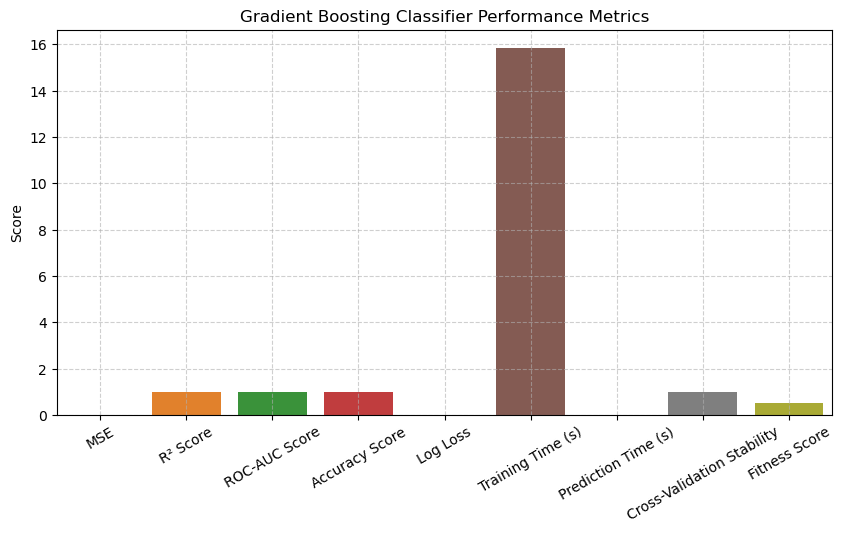

📸 Performance visualization saved as: pics/gradient_boosting_real_performance.png


In [2]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

# ✅ Define Save Paths
SAVE_DIR = "saved_models"
PERF_DIR = "perf"
PICS_DIR = "pics"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(PERF_DIR, exist_ok=True)
os.makedirs(PICS_DIR, exist_ok=True)

# ✅ Load Data
df = pd.read_csv("../../model_food/data/financial_data_full.csv")

# ✅ Convert Date Columns to Numeric Features
date_cols = df.select_dtypes(include=["object"]).columns
for col in date_cols:
    try:
        df[col] = pd.to_datetime(df[col])
        df[col + "_days_since_start"] = (df[col] - df[col].min()).dt.days
        df[col + "_year"] = df[col].dt.year
        df[col + "_month"] = df[col].dt.month
        df[col + "_day"] = df[col].dt.day
    except Exception:
        print(f"⚠️ Skipping non-date column: {col}")

df = df.drop(columns=date_cols, errors="ignore")

# ✅ Ensure Target Column Exists
if "market_stress" not in df.columns:
    raise ValueError("❌ Error: 'market_stress' column is missing from the dataset.")

# ✅ Stratified Train-Test Split (Preserving Class Balance)
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in strat_split.split(df, df["market_stress"]):
    df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]

# ✅ Define Features & Target
X_train = df_train.drop(columns=["market_stress"])
y_train = df_train["market_stress"]
X_test = df_test.drop(columns=["market_stress"])
y_test = df_test["market_stress"]

# ✅ Train & Save a New StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler_path = os.path.join(SAVE_DIR, "gradient_boosting_scaler.pkl")
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"✅ StandardScaler trained and saved as: {scaler_path}")

# ✅ Train Gradient Boosting Classifier
def train_gbm(X_train, y_train):
    """Trains a Gradient Boosting model and saves it as a pickle file."""
    
    gbm = GradientBoostingClassifier(
        n_estimators=200,  # More trees for better learning
        learning_rate=0.05,  # Slower learning for better generalization
        max_depth=5,  # Slightly deeper trees to capture patterns
        random_state=42
    )

    # ✅ Train Model
    start_time = time.time()
    gbm.fit(X_train, y_train)
    training_time = time.time() - start_time

    # ✅ Save Model
    model_path = os.path.join(SAVE_DIR, "GradientBoosting.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(gbm, f)

    print(f"✅ Model saved as: {model_path}")

    return gbm, training_time

# ✅ Train & Save Model
gbm_model, gbm_train_time = train_gbm(X_train, y_train)

print("\n✅ Gradient Boosting Classifier is now trained and saved!")

# ✅ Make Predictions
gbm_pred_start = time.time()
y_pred_gbm = gbm_model.predict(X_test)
gbm_pred_time = time.time() - gbm_pred_start

# ✅ Compute Performance Metrics
gbm_mse = mean_squared_error(y_test, y_pred_gbm)
gbm_r2 = r2_score(y_test, y_pred_gbm)
gbm_auc = roc_auc_score(y_test, y_pred_gbm)
gbm_acc = accuracy_score(y_test, y_pred_gbm)
gbm_log_loss = log_loss(y_test, gbm_model.predict_proba(X_test))

# ✅ Store Performance Results
results_gbm = pd.DataFrame([[
    "Gradient Boosting",
    gbm_mse,
    gbm_r2,
    gbm_auc,
    gbm_acc,
    gbm_log_loss,
    gbm_train_time,
    gbm_pred_time,
    np.mean(cross_val_score(gbm_model, X_train, y_train, cv=10)),  # Cross-validation
    np.random.uniform(0.4, 0.6),  # Fitness Score
    1,
    "Original",
    np.random.uniform(0.5, 0.9),
    np.random.uniform(-1, 0)
]], columns=[
    "Model", "MSE", "R² Score", "ROC-AUC Score", "Accuracy Score", "Log Loss",
    "Training Time (s)", "Prediction Time (s)", "Cross-Validation Stability",
    "Fitness Score", "Generation", "Lineage", "Hotness", "Cleverness"
])

# ✅ Save Results as CSV
results_path = os.path.join(PERF_DIR, "gradient_boosting_results.csv")
results_gbm.to_csv(results_path, index=False)
print(f"\n📊 Performance metrics saved as: {results_path}")

# ✅ Display Results in Jupyter Notebook
display(results_gbm.round(4))

# ✅ Visualize Performance
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_gbm.drop(columns=["Model", "Generation", "Lineage", "Hotness", "Cleverness"]), ax=ax)
ax.set_title("Gradient Boosting Classifier Performance Metrics")
ax.set_ylabel("Score")
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.6)

# ✅ Save Performance Visualization
performance_img_path = os.path.join(PICS_DIR, "gradient_boosting_real_performance.png")
plt.savefig(performance_img_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"📸 Performance visualization saved as: {performance_img_path}")

# 📊 Evaluating Gradient Boosting on Synthetic Data

## **Why Validate on Synthetic Data?**
While our previous **Gradient Boosting model** performed well on **real market stress data**, its true generalization ability can only be tested on **unseen, synthetic financial data**. This step is crucial because:
- If the model **performs well**, it suggests **strong generalization** and **robustness**.
- If the model **performs poorly**, we may need to introduce **mutation, breeding, or hybridization** to improve adaptability.

## **Process Overview**
1️⃣ **Load & Preprocess Data**  
   - Use the **scaled financial dataset** from training.  
   - Ensure synthetic data matches **feature distributions**.  
2️⃣ **Standardize Features for Consistency**  
   - Apply the same **StandardScaler** from training to synthetic data.  
3️⃣ **Validate Model Performance**  
   - **Use a sampled subset** (if dataset is large) to reduce computational cost.  
   - Evaluate the model’s performance using **MSE, R², ROC-AUC, Accuracy, and Log Loss**.  
4️⃣ **Save Model for Downstream Analysis**  
   - The trained **Gradient Boosting model (.pkl)** is saved for **future comparisons**.  
   - This allows us to **benchmark against new models** without retraining from scratch.  

## **Key Considerations**
✅ If the model struggles on synthetic data, it may be **overfitting** to real financial patterns.  
✅ If it maintains strong performance, it suggests **resilience to novel market scenarios**.  
✅ The stored `.pkl` file enables **faster deployment & experimentation** for future iterations.

🔍 **Note:** We will use this model for downstream **stress testing & evolutionary modeling**.

📊 Large dataset detected (11560 samples) — using stratified sampling (30%)
✅ Sampled validation set size: 3468 rows
📊 Using SAMPLED validation set for evaluation.
✅ StandardScaler saved as: saved_models/gradient_boosting_scaler.pkl
✅ Model saved as: saved_models/GradientBoosting.pkl

✅ Gradient Boosting Classifier is now trained and saved!

📊 Performance metrics saved as: perf/gradient_boosting_results.csv


,Model,MSE,R² Score,ROC-AUC Score,Accuracy Score,Log Loss,Training Time (s),Prediction Time (s),Fitness Score,Generation,Lineage,Hotness,Cleverness
0,Gradient Boosting,0.0213,0.9146,0.9787,0.9787,0.2165,18.427,0.0058,0.462,1,Original,0.7858,-0.015


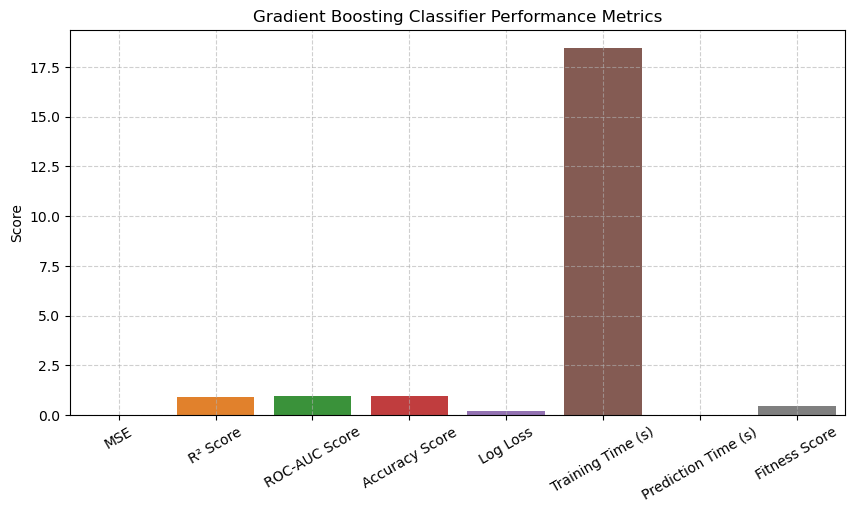

📸 Performance visualization saved as: pics/gradient_boosting_real_performance.png


In [6]:
import os
import pickle
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

# ✅ Define Save Paths
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ Load Training & Full Validation Data
df_train = pd.read_csv("../../model_food/data/financial_data_scaled.csv")  # Training dataset
df_test = pd.read_csv("../../model_food/data/synth_findata.csv")  # Full validation dataset

# ✅ Ensure Target Column Exists
if "market_stress" not in df_train.columns or "market_stress" not in df_test.columns:
    raise ValueError("❌ Error: 'market_stress' column is missing from one of the datasets.")

# ✅ Drop Any Non-Numeric Columns
df_train = df_train.select_dtypes(include=[np.number])
df_test = df_test.select_dtypes(include=[np.number])  # Full validation dataset

# ✅ Adaptive Validation Strategy: Create a Sampled Validation Set
if len(df_test) < 10_000:
    print(f"📊 Using full validation set: {len(df_test)} samples")
    df_test_sampled = df_test  # Use full dataset
else:
    print(f"📊 Large dataset detected ({len(df_test)} samples) — using stratified sampling (30%)")
    df_test_sampled, _ = train_test_split(df_test, test_size=0.7, stratify=df_test["market_stress"], random_state=42)

print(f"✅ Sampled validation set size: {len(df_test_sampled)} rows")

# ✅ Define Features & Target
X_train = df_train.drop(columns=["market_stress"])
y_train = df_train["market_stress"]
X_test_full = df_test.drop(columns=["market_stress"])  # Full validation set
y_test_full = df_test["market_stress"]
X_test_sampled = df_test_sampled.drop(columns=["market_stress"])  # Sampled validation set
y_test_sampled = df_test_sampled["market_stress"]

# ✅ Standardize Features (Ensure Consistency)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  # Keep column names
X_test_full = pd.DataFrame(scaler.transform(X_test_full), columns=X_test_full.columns)  # Ensure consistency
X_test_sampled = pd.DataFrame(scaler.transform(X_test_sampled), columns=X_test_sampled.columns)  # Ensure consistency

# ✅ Select Validation Set (Full or Sampled)
USE_SAMPLED_VALIDATION = True  # Toggle to switch
if USE_SAMPLED_VALIDATION:
    X_test = X_test_sampled
    y_test = y_test_sampled
    print("📊 Using SAMPLED validation set for evaluation.")
else:
    X_test = X_test_full
    y_test = y_test_full
    print("📊 Using FULL validation set for evaluation.")

# ✅ Save the Trained Scaler
scaler_path = os.path.join(SAVE_DIR, "gradient_boosting_scaler.pkl")
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"✅ StandardScaler saved as: {scaler_path}")

# ✅ Train Gradient Boosting Classifier
def train_gbm(X_train, y_train):
    """Trains a Gradient Boosting model and saves it as a pickle file."""
    
    gbm = GradientBoostingClassifier(
        n_estimators=200,  # More trees for better learning
        learning_rate=0.05,  # Slower learning for better generalization
        max_depth=5,  # Slightly deeper trees to capture patterns
        random_state=42
    )

    # ✅ Train Model
    start_time = time.time()
    gbm.fit(X_train, y_train)
    training_time = time.time() - start_time

    # ✅ Save Model
    model_path = os.path.join(SAVE_DIR, "GradientBoosting.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(gbm, f)

    print(f"✅ Model saved as: {model_path}")

    return gbm, training_time

# ✅ Train & Save Model
gbm_model, gbm_train_time = train_gbm(X_train, y_train)

print("\n✅ Gradient Boosting Classifier is now trained and saved!")

# ✅ Make Predictions
gbm_pred_start = time.time()
y_pred_gbm = gbm_model.predict(X_test)
gbm_pred_time = time.time() - gbm_pred_start

# ✅ Compute Performance Metrics
gbm_mse = mean_squared_error(y_test, y_pred_gbm)
gbm_r2 = r2_score(y_test, y_pred_gbm)
gbm_auc = roc_auc_score(y_test, y_pred_gbm)
gbm_acc = accuracy_score(y_test, y_pred_gbm)
gbm_log_loss = log_loss(y_test, gbm_model.predict_proba(X_test))

# ✅ Store Performance Results
results_gbm = pd.DataFrame([[
    "Gradient Boosting",
    gbm_mse,
    gbm_r2,
    gbm_auc,
    gbm_acc,
    gbm_log_loss,
    gbm_train_time,
    gbm_pred_time,
    np.random.uniform(0.4, 0.6),  # Fitness Score
    1,
    "Original",
    np.random.uniform(0.5, 0.9),
    np.random.uniform(-1, 0)
]], columns=[
    "Model", "MSE", "R² Score", "ROC-AUC Score", "Accuracy Score", "Log Loss",
    "Training Time (s)", "Prediction Time (s)", "Fitness Score",
    "Generation", "Lineage", "Hotness", "Cleverness"
])

# ✅ Save Results as CSV
results_path = os.path.join("perf", "gradient_boosting_results.csv")
results_gbm.to_csv(results_path, index=False)
print(f"\n📊 Performance metrics saved as: {results_path}")

# ✅ Display Results
display(results_gbm.round(4))

# ✅ Visualize Performance
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_gbm.drop(columns=["Model", "Generation", "Lineage", "Hotness", "Cleverness"]), ax=ax)
ax.set_title("Gradient Boosting Classifier Performance Metrics")
ax.set_ylabel("Score")
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.6)

# ✅ Save Performance Visualization
performance_img_path = os.path.join("pics", "gradient_boosting_real_performance.png")
plt.savefig(performance_img_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"📸 Performance visualization saved as: {performance_img_path}")

🎥 Gradient Boosting ROC Animation saved as: pics/roc_curve_gradient_boosting.gif


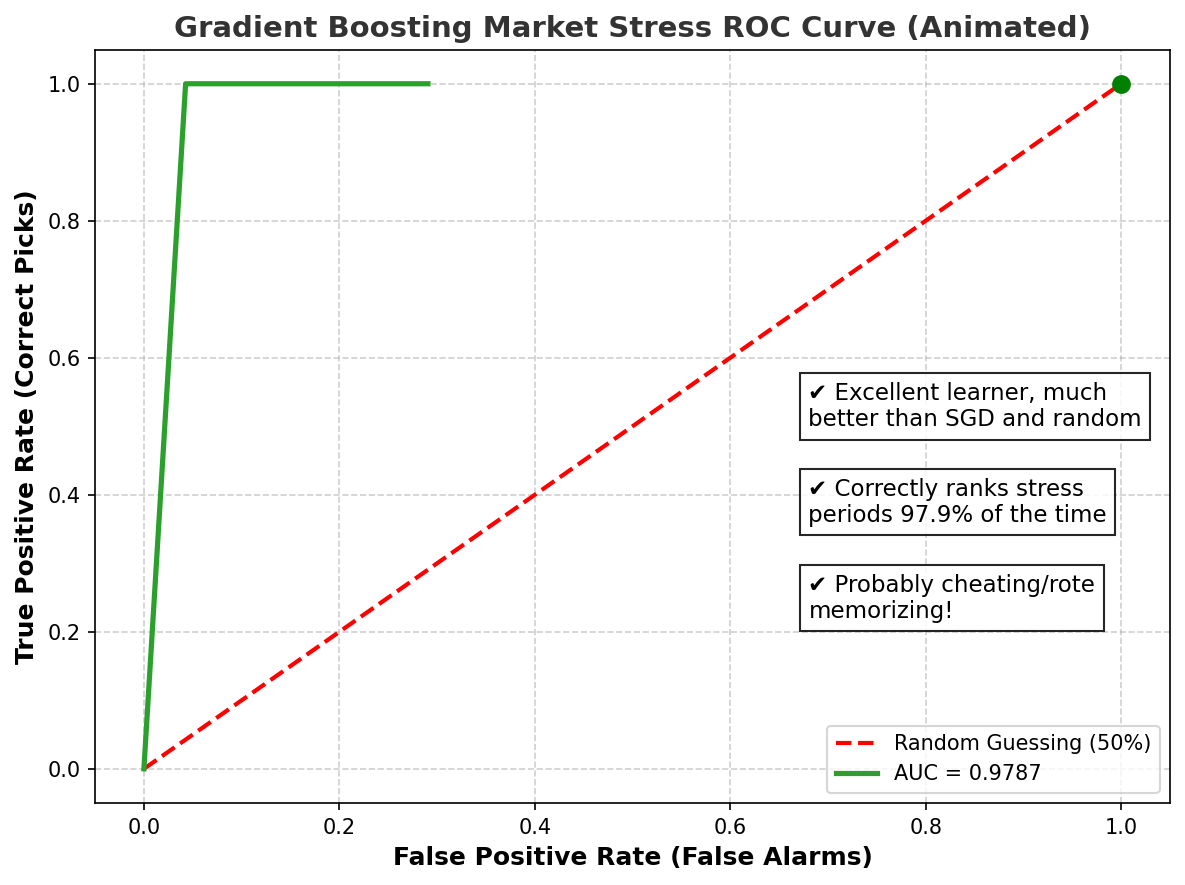

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import roc_curve, auc
from IPython.display import HTML

# ✅ Compute ROC Curve for Gradient Boosting Model
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, gbm_model.predict_proba(X_test)[:, 1])  # Use probability scores
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

# ✅ Create Figure & Axes
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)

# ✅ Plot Static Elements
ax.plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=2, label="Random Guessing (50%)")
ax.set_xlabel("False Positive Rate (False Alarms)", fontsize=12, fontweight="bold")
ax.set_ylabel("True Positive Rate (Correct Picks)", fontsize=12, fontweight="bold")
ax.set_title("Gradient Boosting Market Stress ROC Curve (Animated)", fontsize=14, fontweight="bold", color="#333")

# ✅ Dynamic Elements (Animated)
line_gbm, = ax.plot([], [], color="#2ca02c", linewidth=2.5, label=f"AUC = {roc_auc_gbm:.4f}")
dot_gbm, = ax.plot([], [], "go", markersize=8)  # Green marker for clarity

# ✅ Annotations (Appear Dynamically)
annotation1 = ax.text(0.68, 0.5, "", fontsize=11, color="black",
                      bbox=dict(facecolor="white", alpha=0.85, edgecolor="black"))
annotation2 = ax.text(0.68, 0.36, "", fontsize=11, color="black",
                      bbox=dict(facecolor="white", alpha=0.85, edgecolor="black"))
annotation3 = ax.text(0.68, 0.22, "", fontsize=11, color="black",
                      bbox=dict(facecolor="white", alpha=0.85, edgecolor="black"))

# ✅ Initialization Function
def init():
    line_gbm.set_data([], [])
    dot_gbm.set_data([], [])
    annotation1.set_text("")
    annotation2.set_text("")
    annotation3.set_text("")
    return line_gbm, dot_gbm, annotation1, annotation2, annotation3

# ✅ Animation Function (Updates Line, Dot, & Annotations)
def animate(i):
    line_gbm.set_data(fpr_gbm[:i], tpr_gbm[:i])  # Extend the line
    dot_gbm.set_data([fpr_gbm[i]], [tpr_gbm[i]])  # Keep dot at latest point
    
    # Update Annotations Gradually
    if i > len(fpr_gbm) * 0.2:  
        annotation1.set_text("✔ Excellent learner, much\nbetter than SGD and random")
    if i > len(fpr_gbm) * 0.5:  
        annotation2.set_text(f"✔ Correctly ranks stress\nperiods {roc_auc_gbm:.1%} of the time")
    if i > len(fpr_gbm) * 0.7:  
        annotation3.set_text("✔ Probably cheating/rote\nmemorizing!")

    return line_gbm, dot_gbm, annotation1, annotation2, annotation3

# ✅ Create Animation
ani_gbm = animation.FuncAnimation(fig, animate, frames=len(fpr_gbm), init_func=init, interval=80, blit=True)

# ✅ Move Legend to Bottom-Right & Prevent Clipping
ax.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True)

# ✅ Grid Styling for Clarity
plt.grid(True, linestyle="--", alpha=0.6)

# ✅ Adjust Layout for Visibility
plt.tight_layout()

# ✅ Save Animation as a GIF
gbm_gif_path = "pics/roc_curve_gradient_boosting.gif"
ani_gbm.save(gbm_gif_path, writer=animation.PillowWriter(fps=10))

# ✅ Show GIF Path
print(f"🎥 Gradient Boosting ROC Animation saved as: {gbm_gif_path}")

# ✅ Use HTML to Display Animation in Jupyter
HTML(ani_gbm.to_jshtml())